In [2]:
'''
author: Yike Xie
data: 17/05/2022
content: correlate image features and transcriptome
'''

'\nauthor: Yike Xie\ndata: 17/05/2022\ncontent: correlate image features and transcriptome\n'

In [3]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [3]:
def sg_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pickle.load(f)#pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)

    print('filter adata of single cells')
    adata_s = adata[adata.obs_names.isin(features.index)]

    print('filter genes')
    sc.pp.filter_genes(adata_s, min_cells=10)

    print('Add features to adata')
    for col in ['area', 'length', 'width', 'eccentricity', 'spectrum', 'wavelengths']:
        adata_s.obs[col] = features.loc[adata_s.obs_names][col]
        
    return adata_s

def get_correlation(adata_s, feas):
    #corr = dsim.correlation.correlate_features_phenotypes(feas, fillna=0)##
    exp = adata_s.X.T
    phe = adata_s.obs[feas].fillna(0)

    x = exp #(39466, 10)
    y = phe.values.T #(2, 10)

    from scipy.stats import rankdata

    xw = np.zeros_like(x, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros_like(y, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata_s.var_names,
                    columns=phe.columns,
                    dtype=float)

    return corr

def plot_correlation(genes, adata_s, fea, xlabel, path, filetype=False):
    '''
    genes = {
    'positive': [],
    'negative': []
    }
    '''
    import itertools
    n_genes = len(list(itertools.chain.from_iterable(genes.values())))
    colors = sns.color_palette('tab10', n_genes)
    colors = [colors[: len(genes['positive'])], colors[len(genes['positive']):]]

    fig, axs = plt.subplots(2, 1, figsize=(4, 6), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    for j, (ax, genes) in enumerate(zip(axs, [genes['positive'], genes['negative']])):
        for ig, gene in enumerate(genes):
            x = adata_s.obs[fea]
            y = adata_s[:, gene].X + 0.1
            idx = np.argsort(x)
            ax.scatter(
                x[idx], y[idx], alpha=0.8, label=gene, lw=2, color=colors[j][ig], s=10, 
            )
        ax.legend(fontsize=8, bbox_to_anchor=(1, 1))
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Gene exp [cpm]')
        ax.set_yscale('log')
        ax.set_xscale('log')
#         ax.set_xlim(ax.get_xlim())
#         xticklabels = ['{}×$10^3$'.format(str(i/(10 * (ax.get_xticks()[0] // 10)))) for i in ax.get_xticks()]
#         ax.set_xticklabels(xticklabels)
        #ax.grid(True)
    axs[0].set_title('Positive correlation')
    axs[1].set_title('Negative correlation')
    fig.tight_layout()

    if filetype is not False:
        plt.savefig(save_figures + fea + filetype)
    
    return {'fig': fig, 'axs': axs}

# another method to get correlation
#############################################################################################################
if False:
    corr_a = []
    corr_e = []
    from scipy.stats import pearsonr

    ar = adata_s.X
    area = adata_s.obs['area']
    ecce = adata_s.obs['eccentricity']

    for i, gene in enumerate(adata_s.var_names):
        if i%100 == 0:
            print(i)
        corr_a.append([pearsonr(ar[:,i], area)[0], pearsonr(ar[:,i], area)[1]])
        corr_e.append([pearsonr(ar[:,i], ecce)[0], pearsonr(ar[:,i], ecce)[1]])


    corr_a = pd.DataFrame(corr_a, columns=['correlation', 'pvalue'], index=adata_s.var_names).sort_values('correlation', ascending=False)
    corr_e = pd.DataFrame(corr_e, columns=['correlation', 'pvalue'], index=adata_s.var_names).sort_values('correlation', ascending=False)
#############################################################################################################

In [4]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_imaging/' + 'features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad'
adata_s = sg_dataset(feas_fn, data_fn)

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/'

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


load features
load dataset
filter adata of single cells


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.var` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filter genes
Add features to adata


In [18]:
# Normalize spetrum at (370, 414) by area
adata_s.obs['spectrum_norm'] = np.array(adata_s.obs['spectrum'].tolist()).mean(axis=1) / adata_s.obs['area']
print('Correlate with some simple features')
feas = ['area', 'eccentricity', 'spectrum_norm']

corr = get_correlation(adata_s, feas)
corr.to_csv(save_figures + 'correlation.tsv', sep='\t')

Correlate with some simple features


In [19]:
corr

,area,eccentricity,spectrum_norm
gene_name,,,
TSPAN6,0.155630,-0.001196,0.116237
DPM1,0.124551,-0.001884,-0.327300
SCYL3,0.021797,0.056022,0.051891
C1orf112,0.028744,-0.072269,-0.135220
FUCA2,0.120856,-0.020378,-0.293773
...,...,...,...
RP11-609N14.4,0.267090,0.139190,-0.108511
CH507-9B2.3,0.109517,-0.003003,-0.205628
CTC-351M12.1,-0.003102,0.023742,-0.020321


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


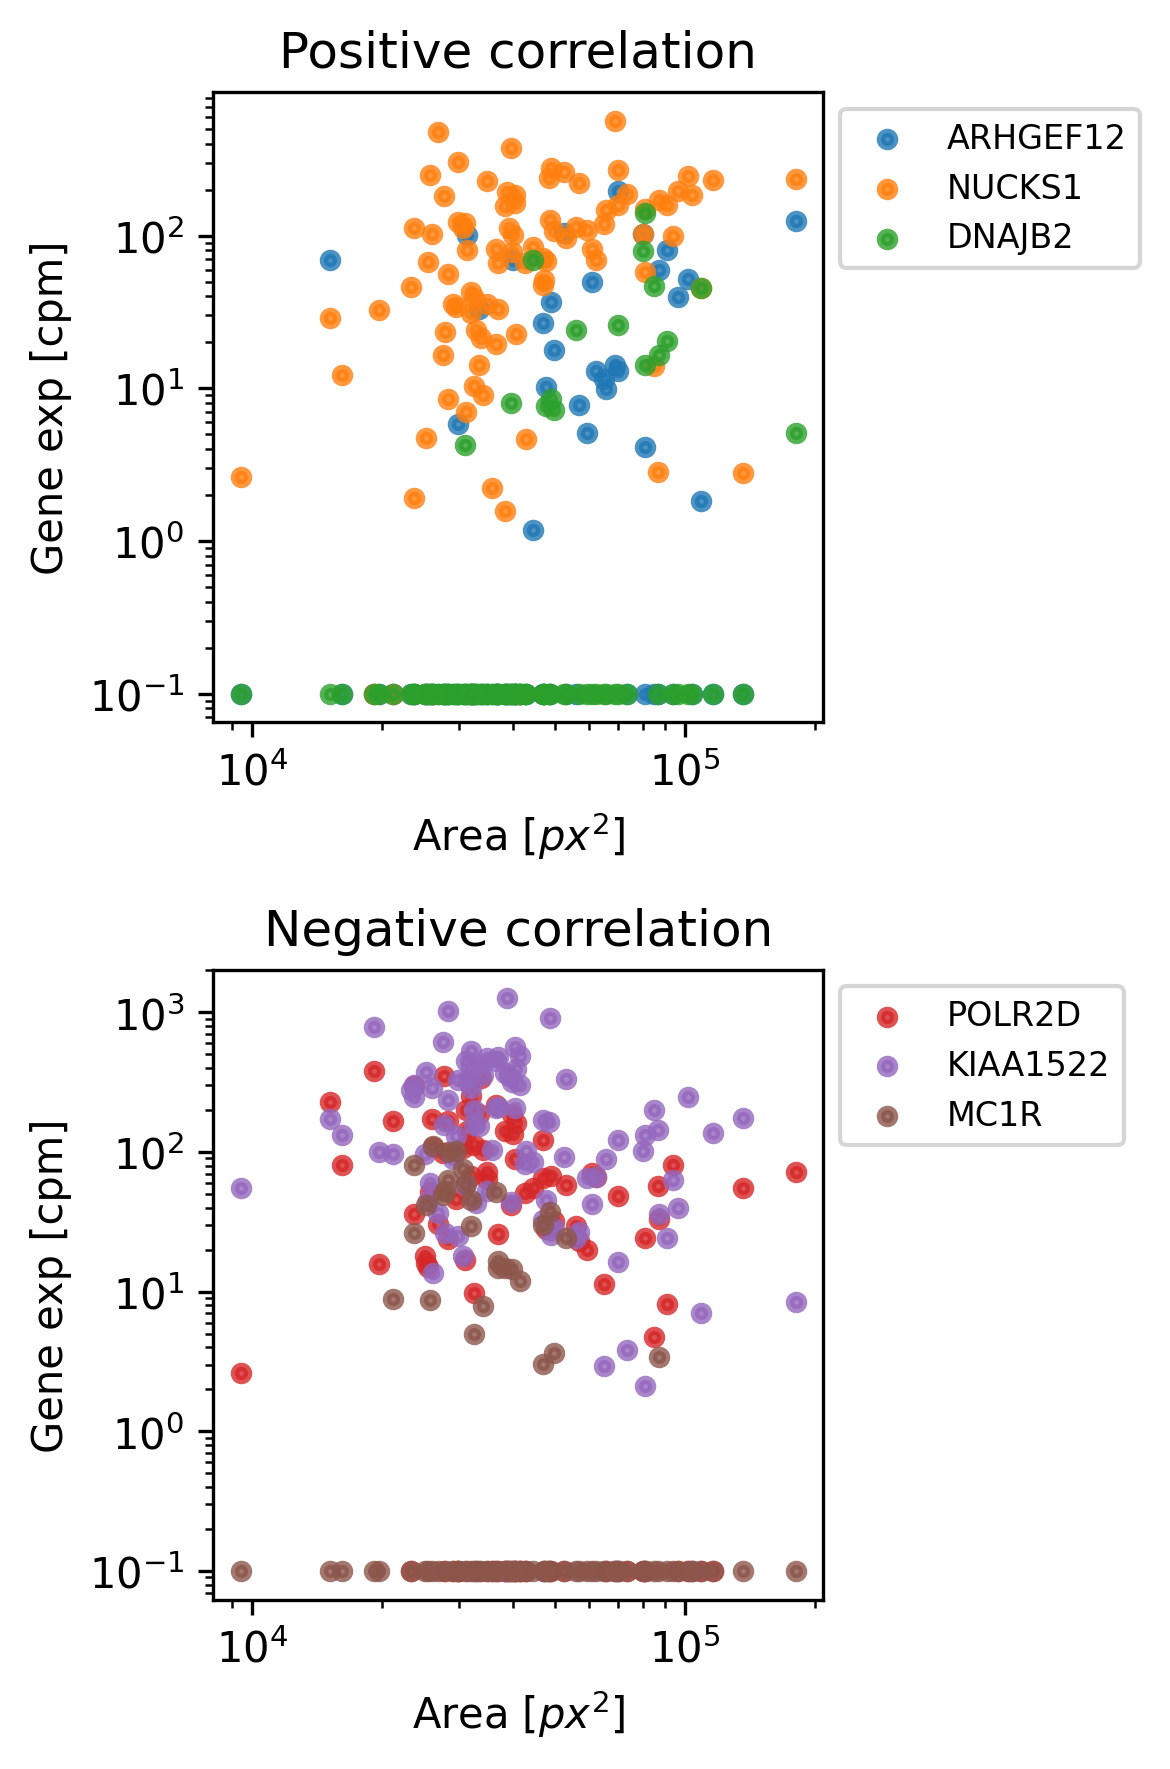

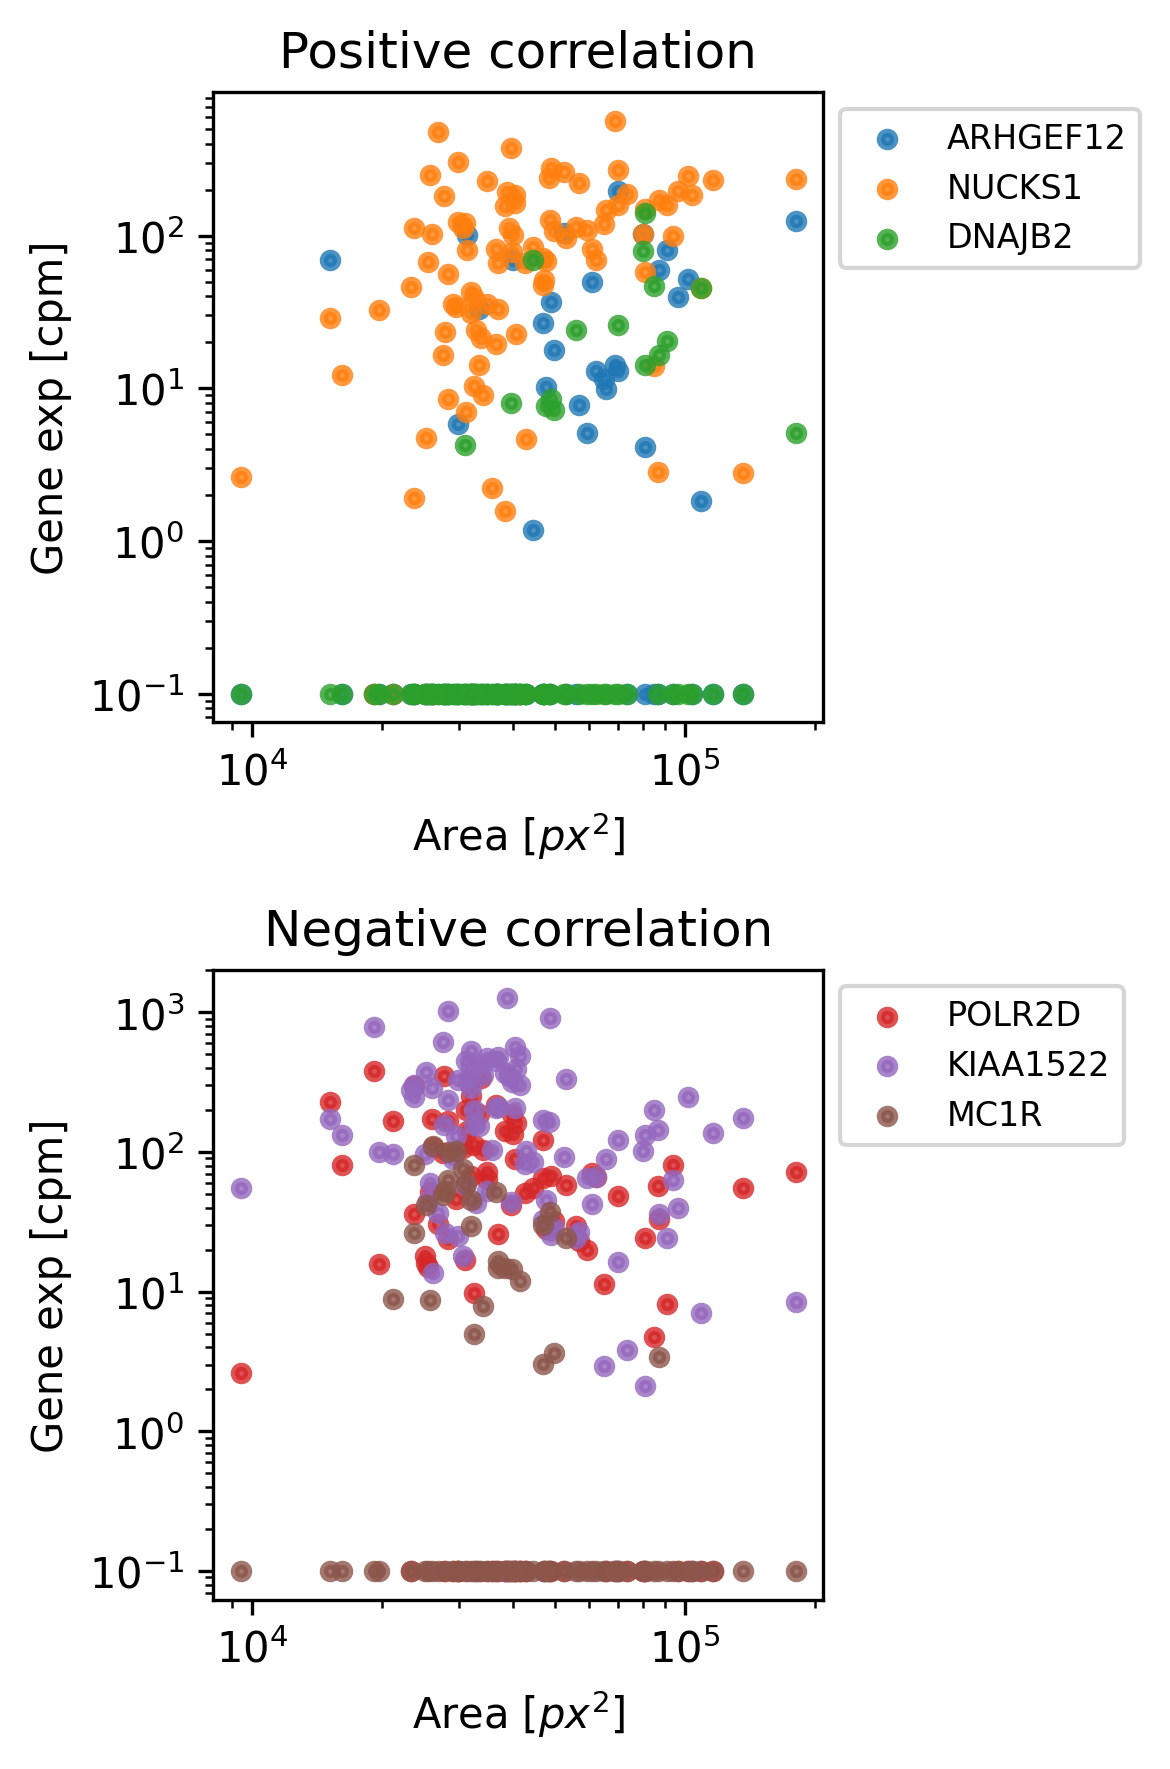

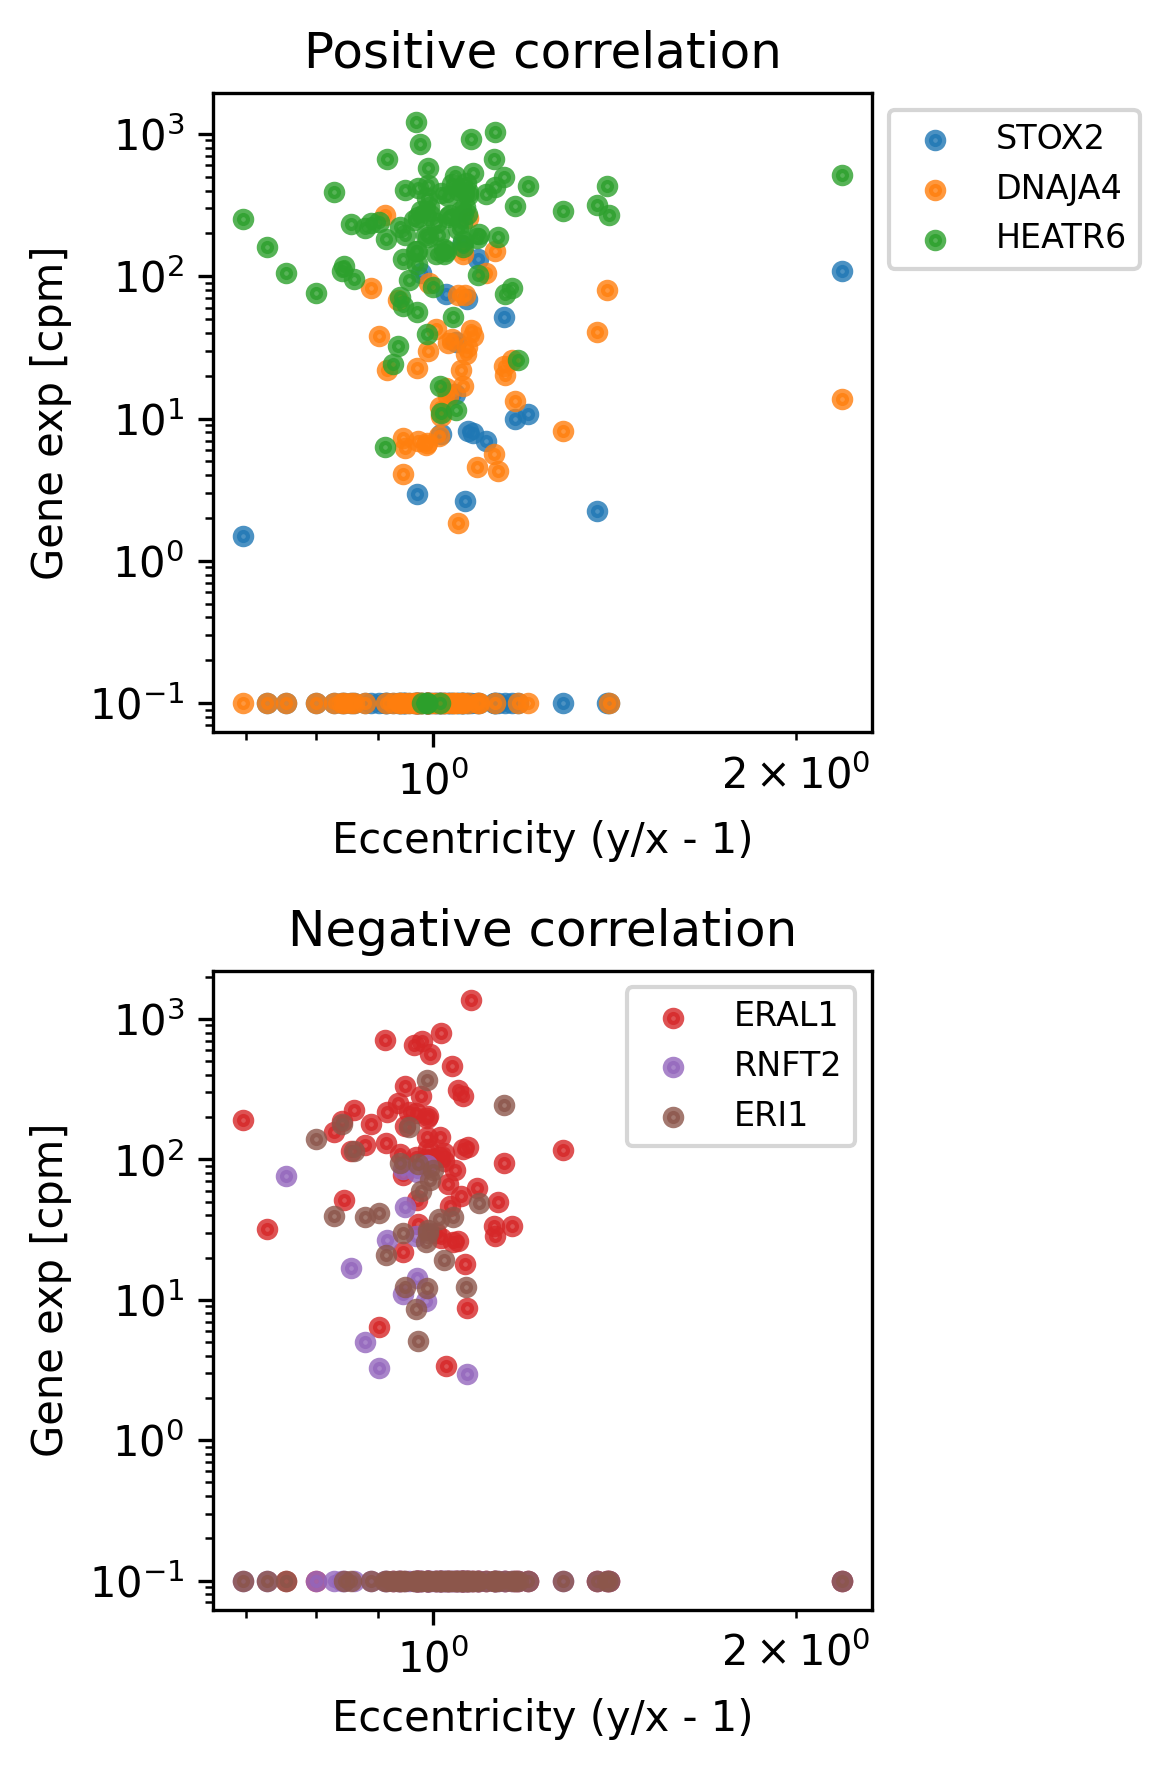

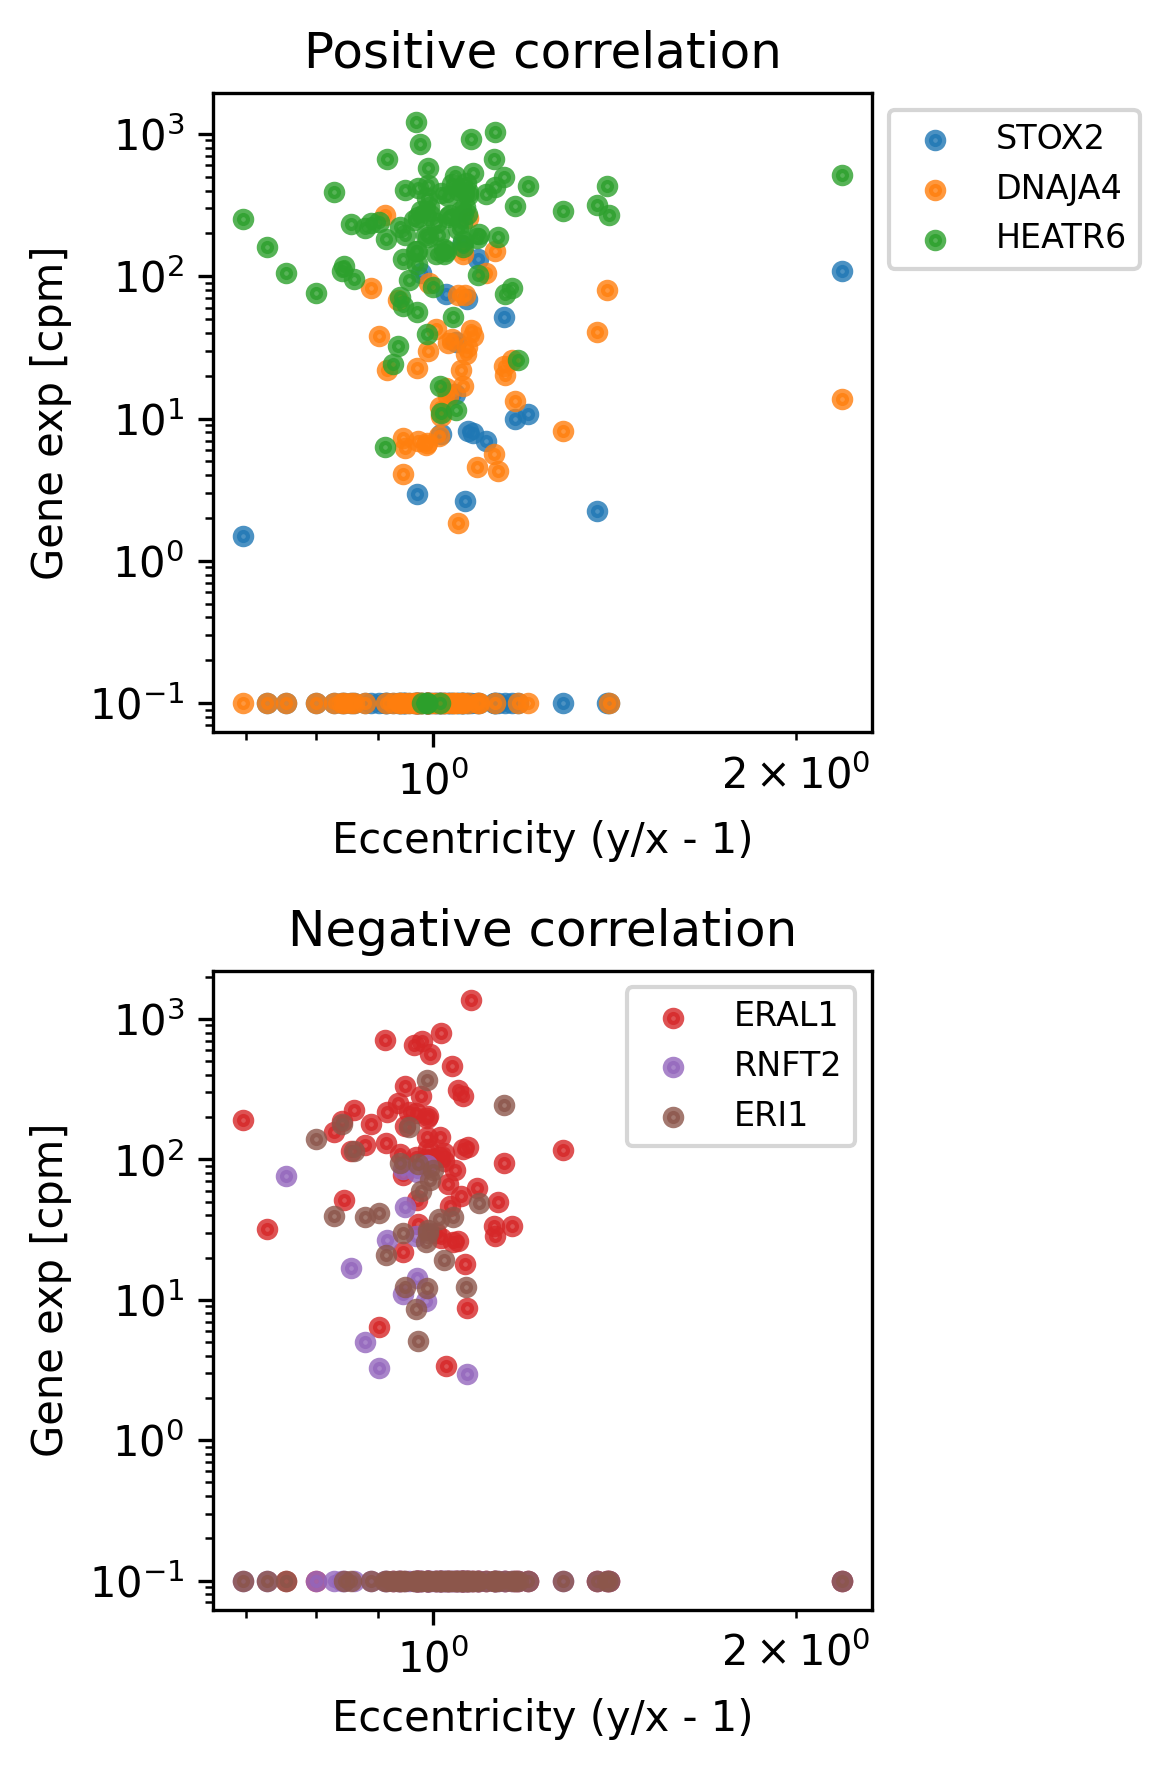

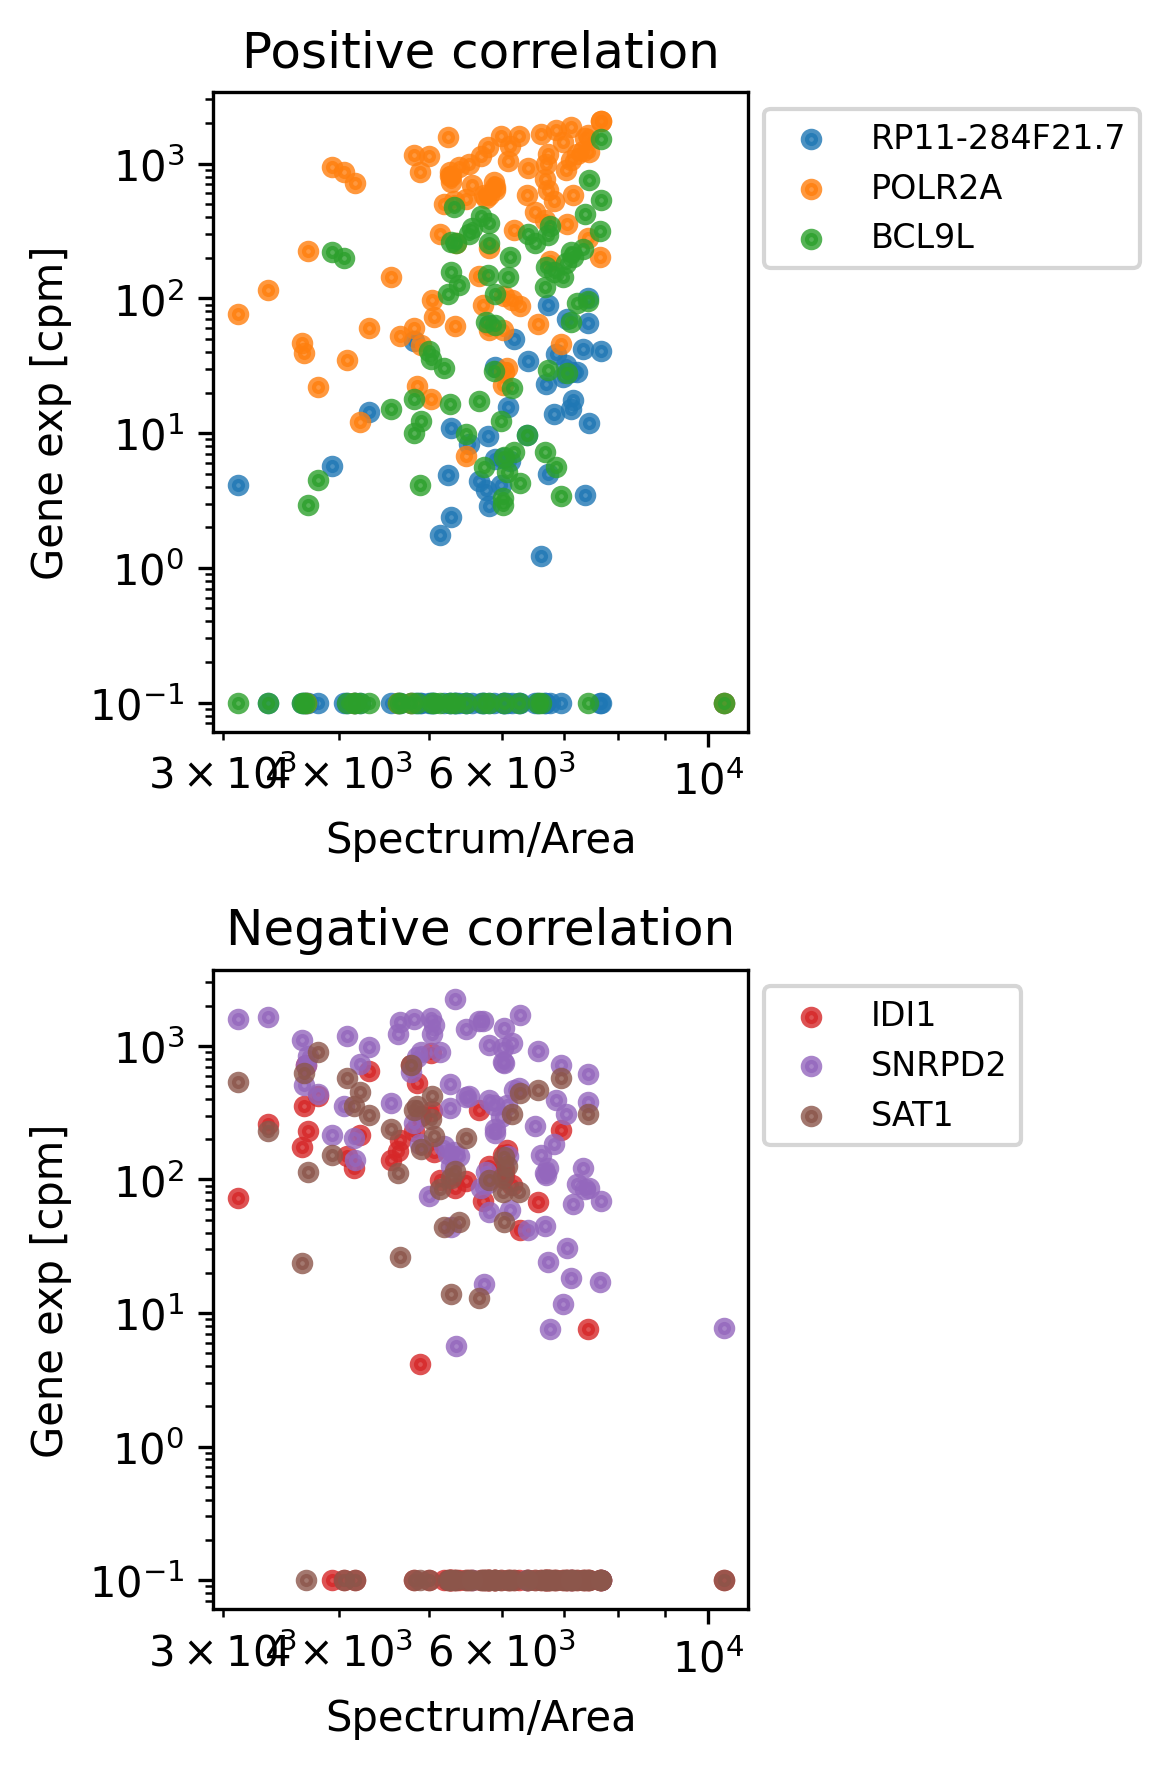

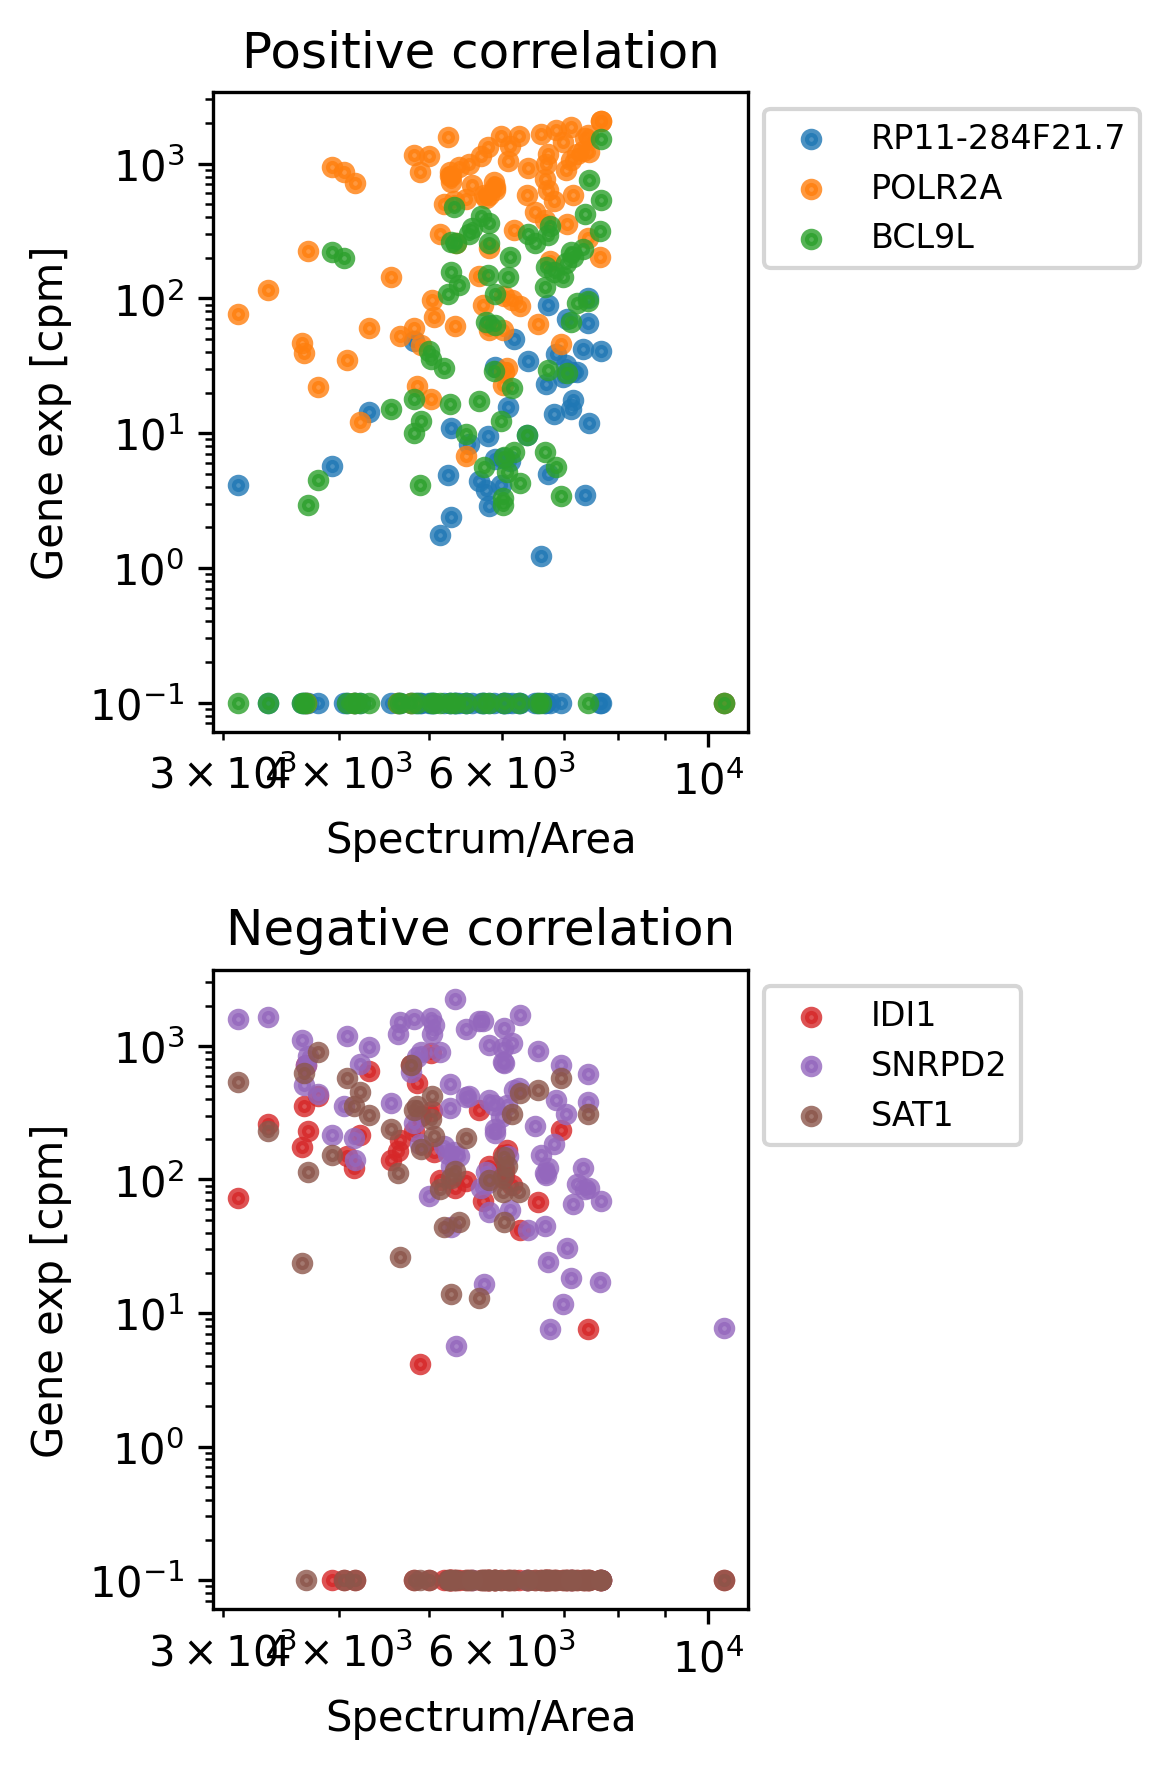

In [22]:
feas = ['area', 'eccentricity', 'spectrum_norm']
xlabels = ['Area [$px^2$]', 'Eccentricity (y/x - 1)', 'Spectrum/Area']

for fea, xlabel in zip(feas, xlabels):

    path = save_figures
    filetype = '.png' 
    genes = {
        'positive': corr.nlargest(3, fea).index.tolist(),
        'negative': corr.nsmallest(3, fea).index.tolist(),
    }
    plot_correlation(genes, adata_s, fea, xlabel, path, filetype='.png')
    plot_correlation(genes, adata_s, fea, xlabel, path, filetype='.pdf')

In [47]:
path = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/cancer100cells/doublets/distance_cells/'
fds = [fn for fn in os.listdir(path) if '.' not in fn]
for fd in fds:
    fns = [fn for fn in os.listdir(path + fd) if 'npz' in fn]
    mask = np.full(np.load(path + fd + '/' + fns[0])['new_segmentation'].shape, False)
    for fn in fns:
        maski = np.load(path + fd + '/' + fn)['new_segmentation']
        mask += maski
        
    img = dict(np.load(path + fd + '/' + fn))
    img['new_segmentation'] =mask
    
    np.savez_compressed(path + fn.split('.')[0][:-1] + '.npz', **img)